In [1]:
import rushd as rd
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from textwrap import wrap

import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:

experimentdir1 = rd.datadir/'flow'/'2023.04.03_Cassette_MEKi_Reprogramming'
experimentdir2 = rd.datadir/'flow'/'2023.06.19_Cassette_MEKi_Reprogramming'
experimentdir3 = rd.datadir/'flow'/'2024.11.04_MEKi_reprogramming'

outputdir = rd.rootdir/'figures'/'MEKi_cassette_reprogramming'

In [3]:
#rd.plot.plot_well_metadata(experimentdir1/'metadata_high-conc.yaml')
#rd.plot.plot_well_metadata(experimentdir1/'metadata_low-conc.yaml')
#rd.plot.plot_well_metadata(experimentdir2/'metadata_high-conc.yaml')
#rd.plot.plot_well_metadata(experimentdir2/'metadata_low-conc.yaml')
#rd.plot.plot_well_metadata(experimentdir3/'metadata.yaml')

# Load Data

In [4]:
data_columns = ['GFP-A']

df1_high = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_high-conc',yaml_path=experimentdir1/'metadata_high-conc.yaml',columns=data_columns)
df1_low = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_low-conc',yaml_path=experimentdir1/'metadata_low-conc.yaml',columns=data_columns)
df2_high = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv_high-conc',yaml_path=experimentdir2/'metadata_high-conc.yaml',columns=data_columns)
df2_low = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv_low-conc',yaml_path=experimentdir2/'metadata_low-conc.yaml',columns=data_columns)
df3 = rd.flow.load_csv_with_metadata(data_path=experimentdir3/'csv',yaml_path=experimentdir3/'metadata.yaml',columns=data_columns)

df1_high['rep'] = '2023.04.03'
df1_low['rep'] = '2023.04.03'
df2_high['rep'] = '2023.06.19'
df2_low['rep'] = '2023.06.19'

df = pd.concat([df1_high,df1_low,df2_high,df2_low,df3])

df['condition'] = df['cassette'] + ' ' + df['MEKi']


Get rid of negative values

In [5]:
for i in np.arange(0,np.size(data_columns)):
    df = df.loc[df[data_columns[i]]>0]


# iMN gate

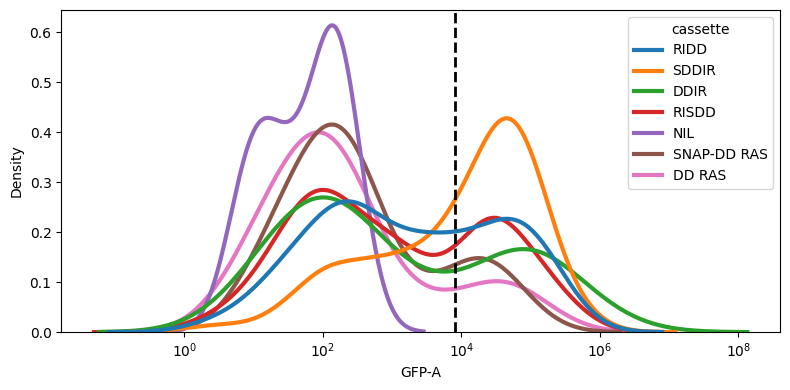

In [6]:
GFP_gate = 8 * 10**3 # Set gate at 8 * 10^3


# Plot gate
plt.figure(figsize=(8,4))
g = sns.kdeplot(data=df.sample(1000),x='GFP-A',hue='cassette',log_scale=True,common_norm=False,linewidth=3)
plt.axvline(x=GFP_gate,linestyle='--',color='black',linewidth=2)
#sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
plt.tight_layout()
plt.show()


# Make summary statistics dataframe

In [7]:
# Make a dataframe with summary statistics such as mean fluorescent intensity (MFI)
groups = ['rep','cassette','MEKi','condition','well']

summary_df = pd.concat([
    df.groupby(groups)['GFP-A'].apply(lambda x: np.mean(x > GFP_gate)*100).rename('(%) iMN\nof all cells'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)).rename('iMN Yield'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)/10000 * 100).rename('(%) iMN yield\nper MEF plated'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.size(x)).rename('Single Cells Count')], axis=1)
summary_df = summary_df.reset_index()

# Statistics you would like to plot later
data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']

# Plotting Functions

In [8]:
def custom_barplot(x,y,data,filename,height=4,width=8,hue=None,xlabel_rot=90,xlabel='',plottitle='',palette='viridis',order=None,hue_order=None,pairs=None,alpha=0.8,reps=None):
    aspect = width / height
    g = sns.catplot(x=x,y=y,data=data,height=height,aspect=aspect,palette=palette,kind='bar',hue=hue,order=order,hue_order=hue_order,alpha=alpha,errorbar='ci',legend=None)
    ax = plt.gca()
    
    if order != None:
        #labels = [ '\n'.join(wrap(l, 4)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if hue == None:
        dodge = False
    elif hue != None:
        dodge = True

    if reps is None:
        g.map_dataframe(sns.stripplot, x=x,y=y, 
                    hue=hue, palette=["#404040"], 
                    alpha=0.8, dodge=dodge,order=order,hue_order=hue_order)
    
    marker_list = ['o', '^', 's', 'D', 'P', 'X']

    if reps is not None:
        for (j, rep) in enumerate(data[reps].unique()):
            sns.stripplot(
                ax=ax, data=data[data[reps] == rep],
                x=x, y=y,
                order=order,
                hue=hue,
                hue_order=hue_order,
                dodge=dodge, marker=marker_list[j],
                palette=['white'], size=5,
                edgecolor='black', linewidth=0.4,
                legend=None)

    if pairs != None:
        annotator = Annotator(ax,pairs,data=data,x=x,y=y,order=order)
        annotator.configure(test='t-test_ind',text_format='star',loc='inside', verbose=2)
        annotator.apply_and_annotate()
        #add_stat_annotation(ax, data=data, x=xcat, y=ycat, order=order,
        #            box_pairs=pairs,
        #            test='t-test_ind', text_format='star', verbose=2)

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
        ax.yaxis.set_major_formatter(k_formatter)

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False) # make plot bounded on all sides
    
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    plt.xlabel(xlabel)
    plt.ylabel(y)
    plt.title(plottitle)

    if hue is not None:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, frameon=False)  # Adjust bbox_to_anchor as needed

    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #g.tight_layout()
    g.savefig(outputdir/str(filename + '.svg'),dpi=300)



def custom_catplot(xcat,ycat,dataslice,savetitle,height=4,width=8,xlabel_rot=0,xlabel='',plottitle='',order=None,palette=None,pairs=None):
    if palette != None:
        hue = xcat
        color = None
    elif palette == None:
        hue = None
        color = '#000000'
    aspect = width / height
    g = sns.catplot(x=xcat,y=ycat,data=dataslice,height=height,aspect=aspect,zorder=1,palette=palette,order=order,hue=hue,color=color,s=70)
    g.map_dataframe(sns.pointplot, x=xcat,y=ycat,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    #sns.pointplot(x=xcat,y=ycat,data=dataslice,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    ax = plt.gca()
    
    #plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))  # this is for if you want scientific y axis labels (e.g. 10^4 instead of 10000)
    if order != None:
        #labels = [ '\n'.join(wrap(l, 16)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if pairs != None:
        annotator = Annotator(g.ax,pairs,data=dataslice,x=xcat,y=ycat,order=order)
        annotator.configure(test='Kruskal',text_format='star',loc='inside')
        annotator.apply_and_annotate()

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    g.tight_layout()
    plt.legend([],[], frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel(ycat)
    plt.title(plottitle)
    
    #g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)


# Plot Results

Formatting

In [9]:
sns.set_theme(style="ticks",font_scale=1)

data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']
savedict = {'(%) iMN yield\nper MEF plated':'yield','(%) iMN\nof all cells':'purity','Single Cells Count':'count'}

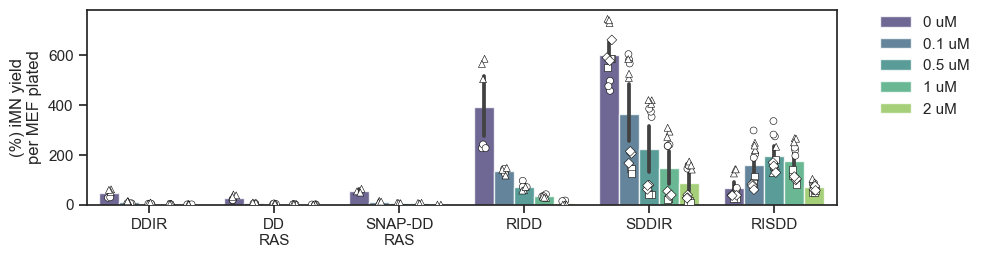

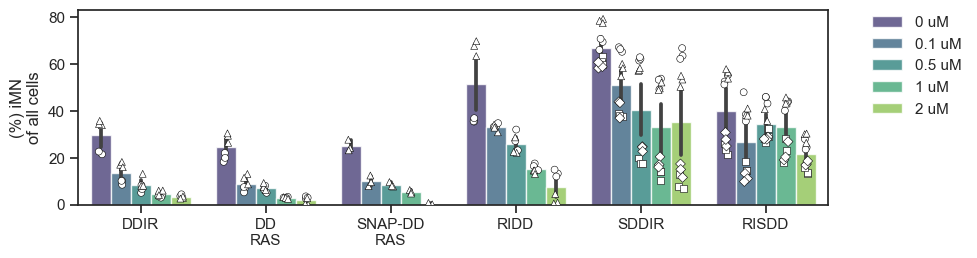

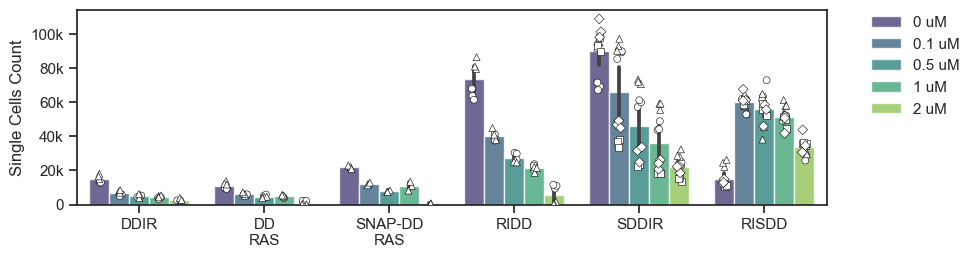

In [10]:
data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']

order = ['DDIR','DD RAS','SNAP-DD RAS','RIDD','SDDIR','RISDD']
#hue_order = ['None', '0 uM (0.1%)','0 uM (1%)', '0.1 uM','0.5 uM','1 uM','5 uM','10 uM']
hue_order = [ '0 uM',             '0.1 uM','0.5 uM','1 uM','2 uM']

for i in data2plot:
    savetitle = savedict[i]
    custom_barplot('cassette',i,summary_df,
                   plottitle='',
                   filename=savetitle,
                   order = order,
                   palette="viridis",
                    hue='MEKi',
                    hue_order=hue_order,
                    height=3,
                    width=10,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep')

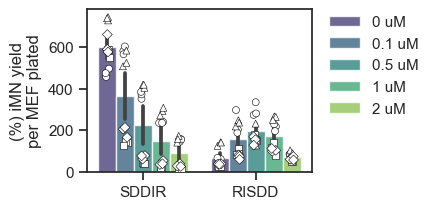

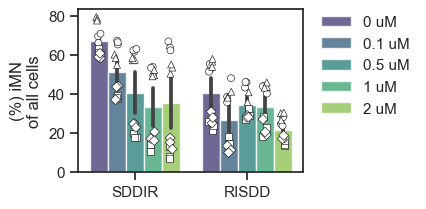

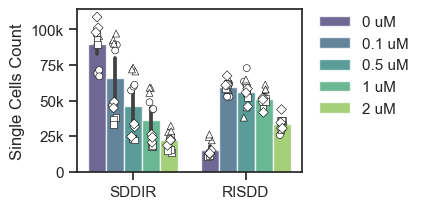

In [11]:
data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']

order = ['SDDIR','RISDD']
hue_order = ['0 uM',             '0.1 uM','0.5 uM','1 uM','2 uM']
#order = ['RISDD']

for i in data2plot:
    savetitle = savedict[i] + '_SDDIR-RISDD'
    #savetitle = savedict[i] + '_RISDD-Only'

    custom_barplot('cassette',i,summary_df[summary_df['cassette'].isin(order)],
                   plottitle='',
                   filename=savetitle,
                   order = order,
                   palette="viridis",
                    hue='MEKi',
                    hue_order=hue_order,
                    height=2.5,
                    width=3,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep')